In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [2]:
df = pd.read_csv("../data/cleaned data/merged_data.csv")
df = df.dropna()

In [3]:
df = df.reset_index(drop=True)
df.index = df.index + 1

In [4]:
null_row = pd.DataFrame([[np.nan] * len(df.columns)], columns=df.columns)
df = pd.concat([null_row, df], ignore_index=True)

In [5]:
characteristics = ["NumberofSchools", "DistrictEnrollment", "PercentofGiftedStudents",
        "CharterSchoolEnrollment", "GeographicSizeofDistrict", "AmericanIndian_AlaskanNative", "Asian", "NativeHawaiianorotherPacificIslander",
       "Black", "Hispanic", "White", "TwoOrMoreRaces", "EconomicallyDisadvantaged", "EnglishLearner", "SpecialEducation", "Female", "Male", 
       "Homeless", "MilitaryConnected", "perc_unconnected_students", "Latitude", "Longitude"]

In [6]:
matched_data = pd.read_csv("../data/cleaned data/matched_data_fromR.csv")

In [7]:
matched_data.sort_values("distance", ascending=True)

,Unnamed: 0,id,subclass,weights,District.Name,DistrictType,Virtual,Hybrid,In_Person,mean_proficient_english_2019,...,SpecialEducation,Female,Male,Homeless,MilitaryConnected,perc_unconnected_students,Latitude,Longitude,treatment,distance
81,82,114,41,1,EASTON AREA SCHOOL DISTRICT,Regular local school district,0,9,0,42.737500,...,-0.381498,-0.206184,0.198349,0.179036,-0.579352,0.998737,40.702372,-75.242444,0,0.070394
80,81,107,41,1,DUQUESNE CITY SCHOOL DISTRICT,Regular local school district,2,2,5,14.200000,...,0.488844,1.863954,-1.867959,2.186648,-0.390646,2.440187,40.371676,-79.847508,1,0.070683
46,47,76,24,1,COLUMBIA BOROUGH SCHOOL DISTRICT,Regular local school district,1,6,2,32.300000,...,1.754797,-2.276322,2.264657,4.194260,-0.201941,2.309146,40.036209,-76.502197,1,0.096014
47,48,8,24,1,AMBRIDGE AREA SCHOOL DISTRICT,Regular local school district,1,5,0,40.525000,...,0.831706,-1.034239,1.024872,0.887605,-0.579352,0.605614,40.591117,-80.225185,0,0.097773
325,326,408,163,1,WEST MIFFLIN AREA SCHOOL DISTRICT,Regular local school district,1,8,0,53.975000,...,1.464683,0.759880,-0.765928,-0.175249,-0.296294,1.260819,40.361245,-79.932768,0,0.099507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,357,402,179,1,WELLSBORO AREA SCHOOL DISTRICT,Regular local school district,0,4,5,48.250000,...,-0.724360,0.414857,-0.421543,-0.234296,-0.013236,-0.180632,41.757722,-77.303646,1,0.834742
122,123,155,62,1,HANOVER PUBLIC SCHOOL DISTRICT,Regular local school district,0,2,7,43.975000,...,-1.278215,-0.827226,0.818241,0.060941,-0.296294,0.736655,39.819955,-76.971212,1,0.850887
142,143,174,72,1,JENKINTOWN SCHOOL DISTRICT,Regular local school district,0,7,2,50.750000,...,-1.779321,2.346986,-2.350098,-1.060960,-0.201941,-1.491042,40.096120,-75.133650,1,0.927232
8,9,17,5,1,BANGOR AREA SCHOOL DISTRICT,Regular local school district,0,6,3,47.433333,...,0.014112,-0.206184,0.198349,-0.470486,-0.107588,-0.180632,40.887670,-75.152564,1,0.981551


In [8]:
# Split data into treatment and control groups based on the treatment column
treated = matched_data[matched_data["treatment"] == 1]
control = matched_data[matched_data["treatment"] == 0]

# Merge treated and control units on the subclass column to create pairs
matched_pairs = pd.merge(
    treated[["id", "subclass"]].rename(columns={"id": "high_policy_index"}), 
    control[["id", "subclass"]].rename(columns={"id": "low_policy_index"}), 
    on="subclass"
)


In [9]:
matched_pairs

,high_policy_index,subclass,low_policy_index
0,7,1,50
1,10,2,53
2,11,3,245
3,13,4,3
4,17,5,365
...,...,...,...
184,421,185,143
185,423,186,306
186,424,187,276
187,425,188,298


In [10]:
# Add column for difference in test scores 
df["english_diff"] = df["mean_proficient_english_2022"] - df["mean_proficient_english_2019"]
df["math_diff"] = df["mean_proficient_math_2022"] - df["mean_proficient_math_2019"]

In [70]:
from scipy.stats import ttest_rel

# Assuming 'matched_pairs' and 'df' are already defined

# Add test score differences for matched pairs
matched_pairs["english_diff_high"] = matched_pairs["high_policy_index"].map(df["english_diff"])
matched_pairs["math_diff_high"] = matched_pairs["high_policy_index"].map(df["math_diff"])
matched_pairs["english_diff_low"] = matched_pairs["low_policy_index"].map(df["english_diff"])
matched_pairs["math_diff_low"] = matched_pairs["low_policy_index"].map(df["math_diff"])

# Calculate pairwise differences
matched_pairs["english_diff_pairs"] = (
    matched_pairs["english_diff_high"] - matched_pairs["english_diff_low"]
)
matched_pairs["math_diff_pairs"] = (
    matched_pairs["math_diff_high"] - matched_pairs["math_diff_low"]
)

# Drop missing values
# english_scores = matched_pairs["english_diff_pairs"]
# math_scores = matched_pairs["math_diff_pairs"].dropna()

# Perform paired t-tests
english_ttest = ttest_rel(matched_pairs["english_diff_high"], matched_pairs["english_diff_low"])
math_ttest = ttest_rel(matched_pairs["math_diff_high"], matched_pairs["math_diff_low"])

# Output the results
print("English T-Test:", english_ttest)
print("Math T-Test:", math_ttest)


English T-Test: TtestResult(statistic=1.8147620952431371, pvalue=0.07115432995790735, df=188)
Math T-Test: TtestResult(statistic=2.5409970194462237, pvalue=0.011861507582346751, df=188)


In [72]:
matched_pairs

,high_policy_index,subclass,low_policy_index,english_diff_high,math_diff_high,english_diff_low,math_diff_low,english_diff_pairs,math_diff_pairs
0,7,1,50,-9.111111,-4.944444,-13.350000,-8.500000,4.238889,3.555556
1,10,2,53,-3.837500,-2.325000,-7.950000,-2.400000,4.112500,0.075000
2,11,3,245,-3.933333,-2.966667,-2.843750,-4.456250,-1.089583,1.489583
3,13,4,3,-3.300000,-3.700000,0.371429,-7.914286,-3.671429,4.214286
4,17,5,365,-4.833333,-4.200000,-6.950000,-5.450000,2.116667,1.250000
...,...,...,...,...,...,...,...,...,...
184,421,185,143,-4.600000,0.750000,-9.540000,-4.420000,4.940000,5.170000
185,423,186,306,-5.371429,-6.157143,3.825000,-1.800000,-9.196429,-4.357143
186,424,187,276,-6.650000,-1.550000,-5.600000,-12.850000,-1.050000,11.300000
187,425,188,298,1.080000,0.680000,-0.900000,-6.250000,1.980000,6.930000


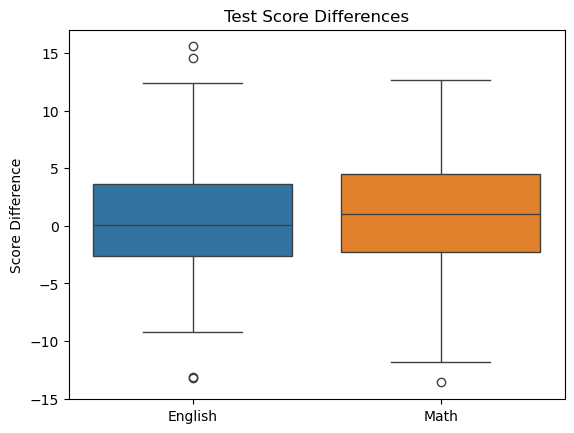

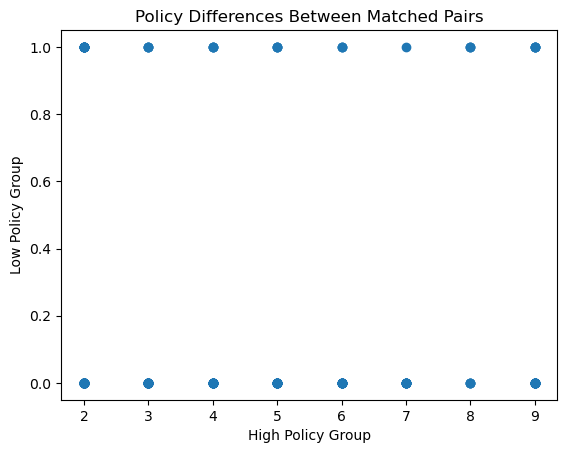

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot of score differences
sns.boxplot(data=matched_pairs[["english_diff_pairs", "math_diff_pairs"]])
plt.title("Test Score Differences")
plt.ylabel("Score Difference")
plt.xticks([0, 1], ["English", "Math"])
plt.show()

# Scatter plot to visualize matches
plt.scatter(df.loc[matched_pairs["high_policy_index"], "In_Person"],
            df.loc[matched_pairs["low_policy_index"], "In_Person"])
plt.title("Policy Differences Between Matched Pairs")
plt.xlabel("High Policy Group")
plt.ylabel("Low Policy Group")
plt.show()

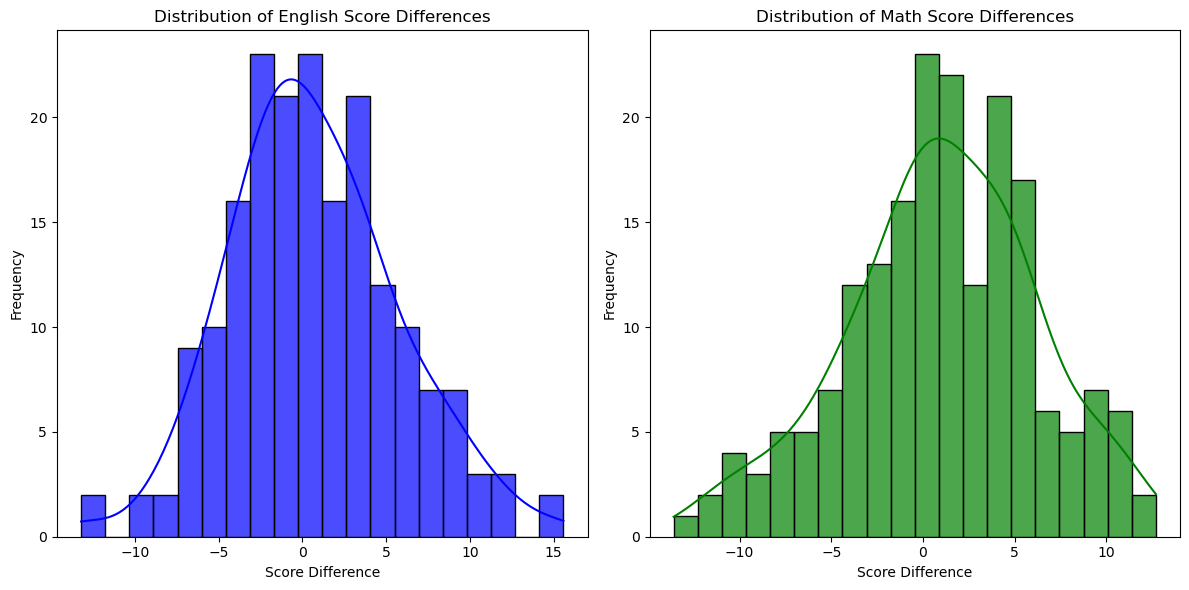

In [76]:
# Histogram of differences
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(matched_pairs["english_diff_pairs"], kde=True, bins=20, color="blue", alpha=0.7)
plt.title("Distribution of English Score Differences")
plt.xlabel("Score Difference")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(matched_pairs["math_diff_pairs"], kde=True, bins=20, color="green", alpha=0.7)
plt.title("Distribution of Math Score Differences")
plt.xlabel("Score Difference")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


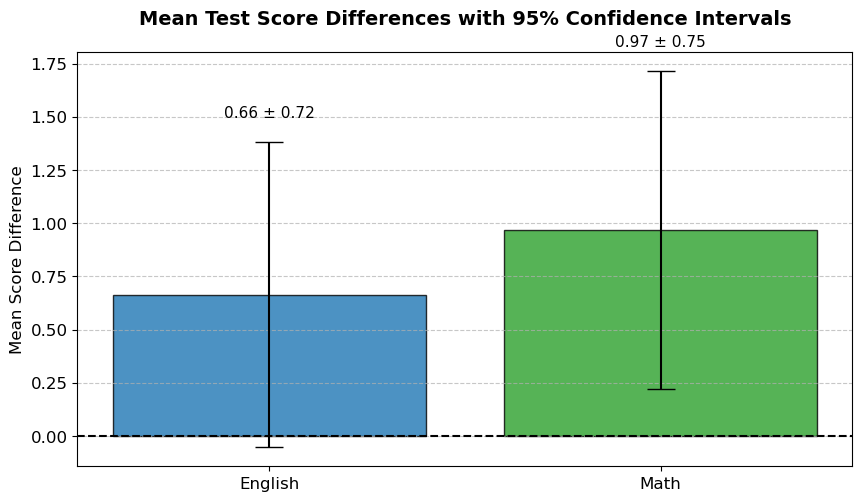

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean differences, standard deviations, and confidence intervals
mean_diffs = matched_pairs[["english_diff_pairs", "math_diff_pairs"]].mean()
std_diffs = matched_pairs[["english_diff_pairs", "math_diff_pairs"]].std()
sample_sizes = matched_pairs[["english_diff_pairs", "math_diff_pairs"]].count()
conf_intervals = 1.96 * (std_diffs / sample_sizes ** 0.5)

# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot the bar chart with error bars
bars = plt.bar(["English", "Math"], mean_diffs, yerr=conf_intervals, capsize=10, color=["#1f77b4", "#2ca02c"], alpha=0.8, edgecolor="black")

# Adding the title and labels
plt.title("Mean Test Score Differences with 95% Confidence Intervals", fontsize=14, fontweight='bold', pad=20)
plt.ylabel("Mean Score Difference", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add horizontal line at y=0 for reference
plt.axhline(0, color="black", linestyle="--", linewidth=1.5)

# Display the confidence interval values on top of the bars
for bar, ci in zip(bars, conf_intervals):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + ci + 0.1, f"{yval:.2f} ± {ci:.2f}", ha="center", va="bottom", fontsize=11, color="black")

# Enhance gridlines for better readability
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Adjust layout to prevent overlap
plt.subplots_adjust(top=0.8)

# Save the plot as a PNG file
plt.savefig("../figures/conf_intervals.png")

# Show the plot
plt.show()


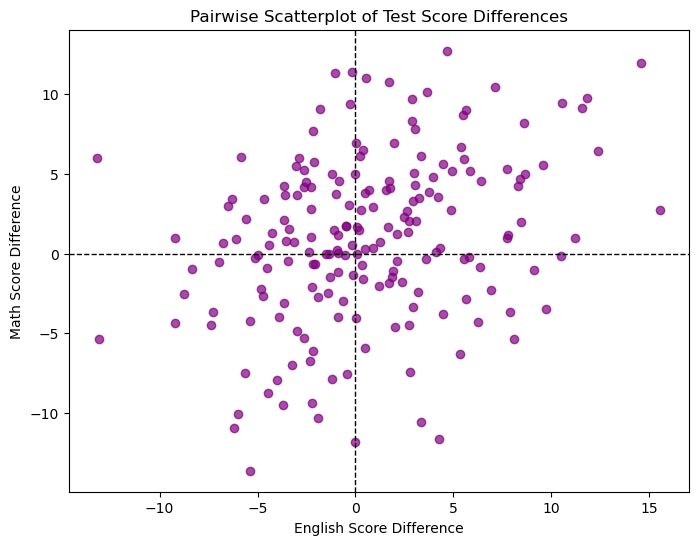

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(matched_pairs["english_diff_pairs"], matched_pairs["math_diff_pairs"], alpha=0.7, color="purple")
plt.title("Pairwise Scatterplot of Test Score Differences")
plt.xlabel("English Score Difference")
plt.ylabel("Math Score Difference")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.show()

In [17]:
import folium

# Create a base map centered on Pennsylvania
map_pa = folium.Map(location=[40.9, -77.8], zoom_start=7, tiles = "CartoDB Positron")  # Centered approximately on Pennsylvania

# Add matched pairs to the map
for _, pair in matched_pairs.iterrows():
    # Get coordinates for the high-policy and low-policy districts
    high_coords = df.loc[pair["high_policy_index"], ["Latitude", "Longitude"]].values
    low_coords = df.loc[pair["low_policy_index"], ["Latitude", "Longitude"]].values

    # Add markers for each district
    folium.Marker(location=high_coords, popup="High Policy Group", icon=folium.Icon(color="blue")).add_to(map_pa)
    folium.Marker(location=low_coords, popup="Low Policy Group", icon=folium.Icon(color="green")).add_to(map_pa)

    # Add a line connecting the matched districts
    folium.PolyLine([high_coords, low_coords], color="red", weight=2).add_to(map_pa)

# Save map as an HTML file or display it in a notebook
map_pa.save("../figures/matched_pairs_map.html")
map_pa

In [18]:
matched_pairs.sort_values("math_diff_pairs", ascending = False)

,high_policy_index,subclass,low_policy_index,english_diff_high,math_diff_high,english_diff_low,math_diff_low,english_diff_pairs,math_diff_pairs
135,316,136,264,-7.800000,-2.600000,-12.500000,-15.300000,4.700000e+00,12.700000
10,31,11,313,9.050000,5.200000,-5.562500,-6.712500,1.461250e+01,11.912500
48,119,49,362,-3.400000,-5.233333,-3.250000,-16.600000,-1.500000e-01,11.366667
186,424,187,276,-6.650000,-1.550000,-5.600000,-12.850000,-1.050000e+00,11.300000
164,382,165,125,-9.700000,1.250000,-10.250000,-9.750000,5.500000e-01,11.000000
...,...,...,...,...,...,...,...,...,...
13,45,14,350,0.466667,-13.300000,-2.875000,-2.725000,3.341667e+00,-10.575000
12,40,13,205,-13.050000,-8.650000,-6.866667,2.300000,-6.183333e+00,-10.950000
99,232,100,376,1.250000,-9.850000,-3.000000,1.750000,4.250000e+00,-11.600000
136,318,137,327,-1.800000,-14.950000,-1.800000,-3.157143,7.105427e-15,-11.792857


In [19]:
df[df["District Name"].str.contains("BIG BEAVER", na=False)]

,District Name,DistrictType,Virtual,Hybrid,In_Person,mean_proficient_english_2019,mean_proficient_math_2019,mean_proficient_english_2022,mean_proficient_math_2022,Unnamed: 0,...,SpecialEducation,Female,Male,Homeless,MilitaryConnected,perc_unconnected_students,Latitude,Longitude,english_diff,math_diff
28,BIG BEAVER FALLS AREA SCHOOL DISTRICT,Regular local school district,0.0,9.0,0.0,40.033333,18.8,35.133333,19.933333,35.0,...,1.886667,0.276848,-0.28379,0.651415,-0.013236,2.440187,40.756013,-80.320815,-4.9,1.133333


In [20]:
matched_pairs[matched_pairs["low_policy_index"] == 28]

,high_policy_index,subclass,low_policy_index,english_diff_high,math_diff_high,english_diff_low,math_diff_low,english_diff_pairs,math_diff_pairs
148,346,149,28,-2.12,-6.3,-4.9,1.133333,2.78,-7.433333


In [21]:
df.iloc[407, ]

District Name                                  WEST MIDDLESEX AREA SCHOOL DISTRICT
DistrictType                                         Regular local school district
Virtual                                                                        0.0
Hybrid                                                                         5.0
In_Person                                                                      4.0
mean_proficient_english_2019                                                  53.0
mean_proficient_math_2019                                                     36.0
mean_proficient_english_2022                                                  47.1
mean_proficient_math_2022                                                27.433333
Unnamed: 0                                                                   471.0
NumberofSchools                                                                3.0
GradesOffered                           K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
Dist

In [22]:
df.iloc[313, ]

District Name                                               RIDLEY SCHOOL DISTRICT
DistrictType                                         Regular local school district
Virtual                                                                        1.0
Hybrid                                                                         8.0
In_Person                                                                      0.0
mean_proficient_english_2019                                                 46.75
mean_proficient_math_2019                                                  31.4625
mean_proficient_english_2022                                               41.1875
mean_proficient_math_2022                                                    24.75
Unnamed: 0                                                                   359.0
NumberofSchools                                                                9.0
GradesOffered                           K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
Dist

In [23]:
df.sort_values("perc_unconnected_students", ascending = False).iloc[1:20, ]

,District Name,DistrictType,Virtual,Hybrid,In_Person,mean_proficient_english_2019,mean_proficient_math_2019,mean_proficient_english_2022,mean_proficient_math_2022,Unnamed: 0,...,SpecialEducation,Female,Male,Homeless,MilitaryConnected,perc_unconnected_students,Latitude,Longitude,english_diff,math_diff
300,POTTSTOWN SCHOOL DISTRICT,Regular local school district,9.0,0.0,0.0,35.120000,21.580000,26.460000,17.460000,346.0,...,1.095446,-0.620212,0.611611,1.537126,-0.579352,2.440187,40.249371,-75.648148,-8.660000,-4.120000
124,FARRELL AREA SCHOOL DISTRICT,Regular local school district,0.0,9.0,0.0,27.650000,8.700000,26.300000,10.350000,144.0,...,3.205367,-1.241253,1.231503,0.651415,1.402054,2.440187,41.212141,-80.484056,-1.350000,1.650000
307,READING SCHOOL DISTRICT,Regular local school district,9.0,0.0,0.0,23.055556,9.688889,18.138889,6.627778,353.0,...,1.359187,-0.137179,0.129472,1.655221,-0.579352,2.440187,40.336919,-75.921965,-4.916667,-3.061111
397,WASHINGTON SCHOOL DISTRICT,Regular local school district,0.0,9.0,0.0,39.250000,21.150000,34.600000,12.050000,460.0,...,1.649301,-0.413198,0.404980,3.072359,-0.484999,2.440187,40.175340,-80.254085,-4.650000,-9.100000
107,DUQUESNE CITY SCHOOL DISTRICT,Regular local school district,2.0,2.0,5.0,14.200000,7.400000,17.200000,3.600000,123.0,...,0.488844,1.863954,-1.867959,2.186648,-0.390646,2.440187,40.371676,-79.847508,3.000000,-3.800000
216,MIDLAND BOROUGH SCHOOL DISTRICT,Regular local school district,2.0,7.0,0.0,47.600000,34.100000,42.200000,20.500000,249.0,...,-0.407872,-2.552341,2.540165,0.179036,-0.579352,2.440187,40.639889,-80.451669,-5.400000,-13.600000
160,HAZLETON AREA SCHOOL DISTRICT,Regular local school district,7.0,2.0,0.0,38.650000,15.862500,32.637500,8.075000,186.0,...,-1.858443,0.276848,-0.214913,-0.234296,-0.579352,2.440187,40.972595,-75.990722,-6.012500,-7.787500
317,ROCHESTER AREA SCHOOL DISTRICT,Regular local school district,1.0,7.0,1.0,45.650000,19.800000,46.450000,23.400000,364.0,...,2.968001,-1.862295,1.920272,0.533320,-0.296294,2.440187,40.707708,-80.277031,0.800000,3.600000
28,BIG BEAVER FALLS AREA SCHOOL DISTRICT,Regular local school district,0.0,9.0,0.0,40.033333,18.800000,35.133333,19.933333,35.0,...,1.886667,0.276848,-0.283790,0.651415,-0.013236,2.440187,40.756013,-80.320815,-4.900000,1.133333
4,ALIQUIPPA SCHOOL DISTRICT,Regular local school district,6.0,2.0,1.0,20.800000,5.450000,19.150000,2.600000,3.0,...,0.647088,-0.482203,0.473857,-0.057154,-0.579352,2.440187,40.609438,-80.279389,-1.650000,-2.850000


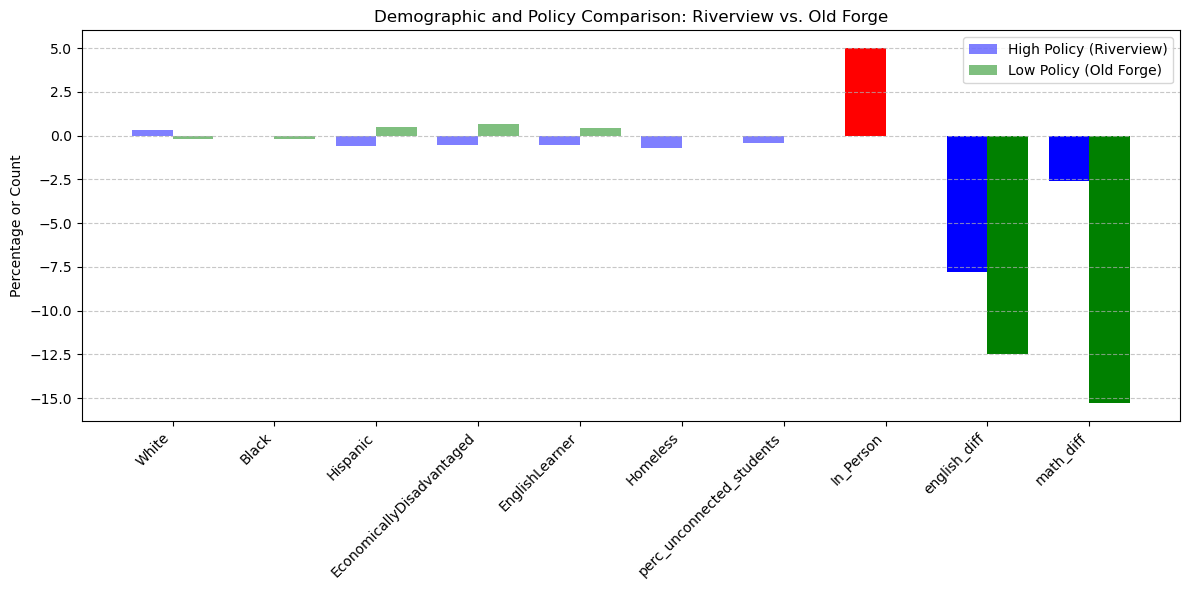

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Filter rows for the two districts
riverview = df[df["District Name"].str.contains("RIVERVIEW", na=False)].iloc[0]  # Extract the first row as Series
oldforge = df[df["District Name"].str.contains("OLD FORGE", na=False)].iloc[0]  # Extract the first row as Series

# Define the columns of interest
labels = [
    "White", "Black", "Hispanic", 
    "EconomicallyDisadvantaged", "EnglishLearner", "Homeless", "perc_unconnected_students", 
    "In_Person", "english_diff", "math_diff"
]

# Extract data for plotting
high_policy = riverview[labels].values  # Extract values for duquesne
low_policy = oldforge[labels].values  # Extract values for easton

x = np.arange(len(labels))  # Generate x positions for each label
bar_width = 0.4  # Width of each bar

# Define colors and alpha for fading and highlighting
faded_color_high = "blue"
faded_color_low = "green"
highlight_color = "red"

colors_high = [highlight_color if label == "In_Person" else faded_color_high for label in labels]
colors_low = [highlight_color if label == "In_Person" else faded_color_low for label in labels]
alphas = [1 if label in ["In_Person", "english_diff", "math_diff"] else 0.5 for label in labels]

# Create the plot
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the bars with adjusted colors and alpha
for i in range(len(labels)):
    plt.bar(x[i] - bar_width / 2, high_policy[i], width=bar_width, color=colors_high[i], alpha=alphas[i], label="High Policy (Riverview)" if i == 0 else "")
    plt.bar(x[i] + bar_width / 2, low_policy[i], width=bar_width, color=colors_low[i], alpha=alphas[i], label="Low Policy (Old Forge)" if i == 0 else "")

# Customize the plot
plt.xticks(x, labels, rotation=45, ha="right")  # Adjust x-axis labels to align between bars
plt.ylabel("Percentage or Count")
plt.title("Demographic and Policy Comparison: Riverview vs. Old Forge")
plt.legend()

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure everything fits
plt.tight_layout()  # Ensure labels and titles fit within the figure

# Save and show the plot
plt.savefig("../figures/riverview_oldforge.png")
plt.show()


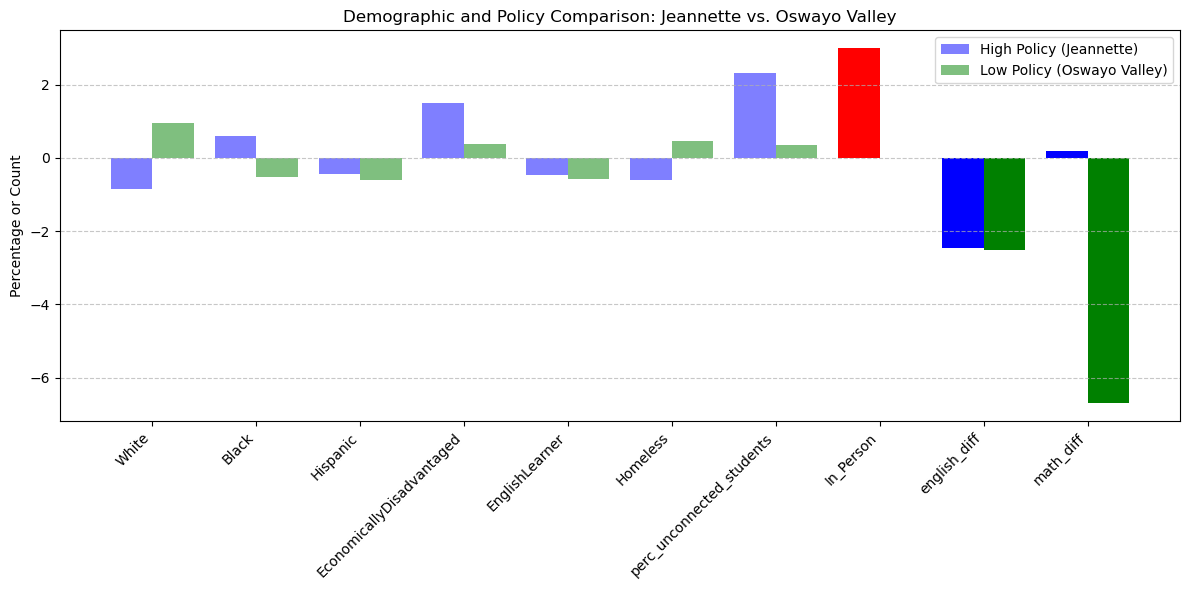

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Filter rows for the two districts
jeanette = df[df["District Name"].str.contains("JEANNETTE", na=False)].iloc[0]  # Extract the first row as Series
oswayo = df[df["District Name"].str.contains("OSWAYO VALLEY", na=False)].iloc[0]  # Extract the first row as Series

# Define the columns of interest
labels = [
    "White", "Black", "Hispanic", 
    "EconomicallyDisadvantaged", "EnglishLearner", "Homeless", "perc_unconnected_students", 
    "In_Person", "english_diff", "math_diff"
]

# Extract data for plotting
high_policy = jeanette[labels].values  # Extract values for Jeannette
low_policy = oswayo[labels].values  # Extract values for Big Beaver

x = np.arange(len(labels))  # Generate x positions for each label
bar_width = 0.4  # Width of each bar

# Define colors and alpha for fading and highlighting
faded_color_high = "blue"
faded_color_low = "green"
highlight_color = "red"

colors_high = [highlight_color if label == "In_Person" else faded_color_high for label in labels]
colors_low = [highlight_color if label == "In_Person" else faded_color_low for label in labels]
alphas = [1 if label in ["In_Person", "english_diff", "math_diff"] else 0.5 for label in labels]

# Create the plot
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the bars with adjusted colors and alpha
for i in range(len(labels)):
    plt.bar(x[i] - bar_width / 2, high_policy[i], width=bar_width, color=colors_high[i], alpha=alphas[i], label="High Policy (Jeannette)" if i == 0 else "")
    plt.bar(x[i] + bar_width / 2, low_policy[i], width=bar_width, color=colors_low[i], alpha=alphas[i], label="Low Policy (Oswayo Valley)" if i == 0 else "")

# Customize the plot
plt.xticks(x, labels, rotation=45, ha="right")  # Adjust x-axis labels to align between bars
plt.ylabel("Percentage or Count")
plt.title("Demographic and Policy Comparison: Jeannette vs. Oswayo Valley")
plt.legend()

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure everything fits
plt.tight_layout()  # Ensure labels and titles fit within the figure

# Save and show the plot
plt.savefig("../figures/jeannette_oswayo_highlighted.png")
plt.show()


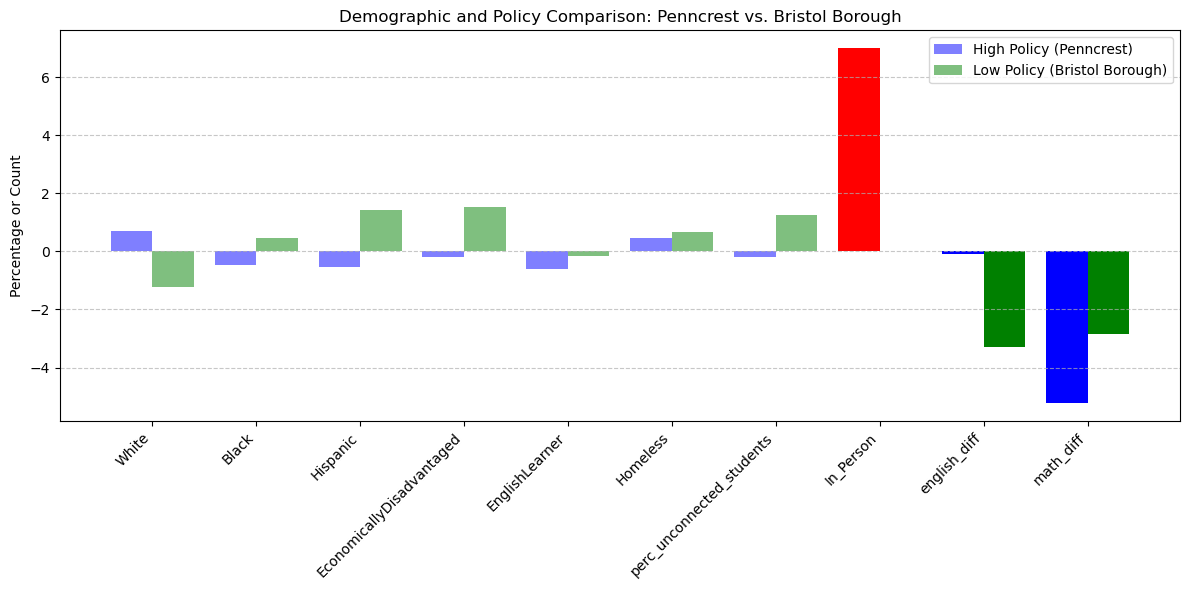

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Filter rows for the two districts
jeanette = df[df["District Name"].str.contains("PENNCREST", na=False)].iloc[0]  # Extract the first row as Series
bristol = df[df["District Name"].str.contains("BRISTOL BOROUGH", na=False)].iloc[0]  # Extract the first row as Series

# Define the columns of interest
labels = [
    "White", "Black", "Hispanic", 
    "EconomicallyDisadvantaged", "EnglishLearner", "Homeless", "perc_unconnected_students", 
    "In_Person", "english_diff", "math_diff"
]

# Extract data for plotting
high_policy = jeanette[labels].values  # Extract values for Jeannette
low_policy = bristol[labels].values  # Extract values for Big Beaver

x = np.arange(len(labels))  # Generate x positions for each label
bar_width = 0.4  # Width of each bar

# Define colors and alpha for fading and highlighting
faded_color_high = "blue"
faded_color_low = "green"
highlight_color = "red"

colors_high = [highlight_color if label == "In_Person" else faded_color_high for label in labels]
colors_low = [highlight_color if label == "In_Person" else faded_color_low for label in labels]
alphas = [1 if label in ["In_Person", "english_diff", "math_diff"] else 0.5 for label in labels]

# Create the plot
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot the bars with adjusted colors and alpha
for i in range(len(labels)):
    plt.bar(x[i] - bar_width / 2, high_policy[i], width=bar_width, color=colors_high[i], alpha=alphas[i], label="High Policy (Penncrest)" if i == 0 else "")
    plt.bar(x[i] + bar_width / 2, low_policy[i], width=bar_width, color=colors_low[i], alpha=alphas[i], label="Low Policy (Bristol Borough)" if i == 0 else "")

# Customize the plot
plt.xticks(x, labels, rotation=45, ha="right")  # Adjust x-axis labels to align between bars
plt.ylabel("Percentage or Count")
plt.title("Demographic and Policy Comparison: Penncrest vs. Bristol Borough")
plt.legend()

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ensure everything fits
plt.tight_layout()  # Ensure labels and titles fit within the figure

# Save and show the plot
plt.savefig("../figures/penncrest_bristol_highlighted.png")
plt.show()


In [27]:
import folium

# Create a base map centered on Pennsylvania
map_pa = folium.Map(location=[40.9, -77.8], zoom_start=7, tiles="CartoDB Positron")  # Centered approximately on Pennsylvania

# Define coordinates for highlighted pairs (Riverview and Old Forge)
highlighted_pairs = [
    {"high_policy_index": "Riverview", "low_policy_index": "Old Forge"}
]

# Add all matched pairs to the map with smaller circles and muted colors
for _, pair in matched_pairs.iterrows():
    # Get coordinates for the high-policy and low-policy districts
    high_coords = df.loc[pair["high_policy_index"], ["Latitude", "Longitude"]].values
    low_coords = df.loc[pair["low_policy_index"], ["Latitude", "Longitude"]].values

    # Add smaller circles for non-highlighted districts
    folium.CircleMarker(location=high_coords, radius=4, color="lightblue", fill=True, fill_opacity=0.5).add_to(map_pa)
    folium.CircleMarker(location=low_coords, radius=4, color="lightgreen", fill=True, fill_opacity=0.5).add_to(map_pa)

    # Add muted lines connecting the matched districts
    folium.PolyLine([high_coords, low_coords], color="gray", weight=1, opacity=0.4).add_to(map_pa)

# Highlight the selected pairs (Riverview and Old Forge) with larger circles
for pair in highlighted_pairs:
    # Get coordinates for the highlighted districts
    high_coords = df.loc[df["District Name"].str.contains(pair["high_policy_index"].upper(), na=False), ["Latitude", "Longitude"]].values[0]
    low_coords = df.loc[df["District Name"].str.contains(pair["low_policy_index"].upper(), na=False), ["Latitude", "Longitude"]].values[0]

    # Add large circles for highlighted districts
    folium.CircleMarker(
        location=high_coords, 
        radius=10,  # Larger radius for emphasis
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.9,
        popup="Highlighted: High Policy Group (Riverview)"
    ).add_to(map_pa)

    folium.CircleMarker(
        location=low_coords, 
        radius=10,  # Larger radius for emphasis
        color="green",
        fill=True,
        fill_color="green",
        fill_opacity=0.9,
        popup="Highlighted: Low Policy Group (Old Forge)"
    ).add_to(map_pa)

    # Add bold lines connecting the highlighted districts
    folium.PolyLine([high_coords, low_coords], color="red", weight=3).add_to(map_pa)

# Save map as an HTML file or display it in a notebook
map_pa.save("../figures/matched_pairs_highlighted_map_large.html")
map_pa


In [28]:
import folium

# Create a base map centered on Pennsylvania
map_pa = folium.Map(location=[40.9, -77.8], zoom_start=7, tiles="CartoDB Positron")  # Centered approximately on Pennsylvania

# Define coordinates for highlighted pairs (Jeannette and Oswayo Valley)
highlighted_pairs = [
    {"high_policy_index": "Jeannette", "low_policy_index": "Oswayo Valley"}
]

# Add all matched pairs to the map with smaller circles and muted colors
for _, pair in matched_pairs.iterrows():
    # Get coordinates for the high-policy and low-policy districts
    high_coords = df.loc[pair["high_policy_index"], ["Latitude", "Longitude"]].values
    low_coords = df.loc[pair["low_policy_index"], ["Latitude", "Longitude"]].values

    # Add smaller circles for non-highlighted districts
    folium.CircleMarker(location=high_coords, radius=4, color="lightblue", fill=True, fill_opacity=0.5).add_to(map_pa)
    folium.CircleMarker(location=low_coords, radius=4, color="lightgreen", fill=True, fill_opacity=0.5).add_to(map_pa)

    # Add muted lines connecting the matched districts
    folium.PolyLine([high_coords, low_coords], color="gray", weight=1, opacity=0.4).add_to(map_pa)

# Highlight the selected pairs (Jeannette and Big Beaver) with larger circles
for pair in highlighted_pairs:
    # Get coordinates for the highlighted districts
    high_coords = df.loc[df["District Name"].str.contains(pair["high_policy_index"].upper(), na=False), ["Latitude", "Longitude"]].values[0]
    low_coords = df.loc[df["District Name"].str.contains(pair["low_policy_index"].upper(), na=False), ["Latitude", "Longitude"]].values[0]

    # Add large circles for highlighted districts
    folium.CircleMarker(
        location=high_coords, 
        radius=10,  # Larger radius for emphasis
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.9,
        popup="Highlighted: High Policy Group (Jeannette)"
    ).add_to(map_pa)

    folium.CircleMarker(
        location=low_coords, 
        radius=10,  # Larger radius for emphasis
        color="green",
        fill=True,
        fill_color="green",
        fill_opacity=0.9,
        popup="Highlighted: Low Policy Group (Oswayo Valley)"
    ).add_to(map_pa)

    # Add bold lines connecting the highlighted districts
    folium.PolyLine([high_coords, low_coords], color="red", weight=3).add_to(map_pa)

# Save map as an HTML file or display it in a notebook
map_pa.save("../figures/matched_pairs_highlighted_map_large.html")
map_pa


In [29]:
import folium

# Create a base map centered on Pennsylvania
map_pa = folium.Map(location=[40.9, -77.8], zoom_start=7, tiles="CartoDB Positron")  # Centered approximately on Pennsylvania

# Define coordinates for highlighted pairs (Jeannette and Bristol Borough)
highlighted_pairs = [
    {"high_policy_index": "Penncrest", "low_policy_index": "Bristol Borough"}
]

# Add all matched pairs to the map with smaller circles and muted colors
for _, pair in matched_pairs.iterrows():
    # Get coordinates for the high-policy and low-policy districts
    high_coords = df.loc[pair["high_policy_index"], ["Latitude", "Longitude"]].values
    low_coords = df.loc[pair["low_policy_index"], ["Latitude", "Longitude"]].values

    # Add smaller circles for non-highlighted districts
    folium.CircleMarker(location=high_coords, radius=4, color="lightblue", fill=True, fill_opacity=0.5).add_to(map_pa)
    folium.CircleMarker(location=low_coords, radius=4, color="lightgreen", fill=True, fill_opacity=0.5).add_to(map_pa)

    # Add muted lines connecting the matched districts
    folium.PolyLine([high_coords, low_coords], color="gray", weight=1, opacity=0.4).add_to(map_pa)

# Highlight the selected pairs (Jeannette and Big Beaver) with larger circles
for pair in highlighted_pairs:
    # Get coordinates for the highlighted districts
    high_coords = df.loc[df["District Name"].str.contains(pair["high_policy_index"].upper(), na=False), ["Latitude", "Longitude"]].values[0]
    low_coords = df.loc[df["District Name"].str.contains(pair["low_policy_index"].upper(), na=False), ["Latitude", "Longitude"]].values[0]

    # Add large circles for highlighted districts
    folium.CircleMarker(
        location=high_coords, 
        radius=10,  # Larger radius for emphasis
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.9,
        popup="Highlighted: High Policy Group (Jeannette)"
    ).add_to(map_pa)

    folium.CircleMarker(
        location=low_coords, 
        radius=10,  # Larger radius for emphasis
        color="green",
        fill=True,
        fill_color="green",
        fill_opacity=0.9,
        popup="Highlighted: Low Policy Group (Bristol Borough)"
    ).add_to(map_pa)

    # Add bold lines connecting the highlighted districts
    folium.PolyLine([high_coords, low_coords], color="red", weight=3).add_to(map_pa)

# Save map as an HTML file or display it in a notebook
map_pa.save("../figures/matched_pairs_highlighted_map_large.html")
map_pa
